# CEASaclay data - Library

Imports and definitions

GENERATE NOISE SPECTRUM
- Generate noise impacts (TESGENIMPACTS)
- Generate noise records from noise impacts (XIFUSIM)
- Generate noise spectrum (GENNOISESPEC)
 
GENERATE PULSES TEMPLATE (20000 ISOLATED 6keV PULSES)
- Generate pulses template impacts (TESCONSTPILEUP)
- Generate pulses template records (XIFUSIM)

BUILD THE LIBRARY (6keV)

## Imports and definitions

In [1]:
import os
import tempfile
import shlex

from subprocess import check_call, STDOUT

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import numpy as np

#%matplotlib notebook

#import ipywidgets as widgets
#%matplotlib widget

#%matplotlib inline

#%matplotlib ipympl

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
# PARAMETERS
preBuffer = 3500 # free samples before pulse triggering (samples)
pulse_length = 8192 # length for reconstruction (samples)
pulse_distance = 20000 # separation between consecutive isolated pulses (samples) >> pulse_length#
recordSeparation = 20000 # distance (samples ) between consecutive records
name_root = "config_xifu_50x30_v5_v20250621"

In [3]:
XMLxifusim = name_root + ".xml"

#samprate = 130208.3  # sampling frequency
# Sampling rate
config = fits.open(name_root + ".fits", memmap=True)
tclock = config["GEOCHANNELPARAM"].header["TCLOCK"]
dec_fac = config["GEOCHANNELPARAM"].header["DEC_FAC"]
config.close()
samprate = 1/(tclock*dec_fac)
#print("Sampling rate: ", samprate, " samples/seg")

tstart = 3*pow(10,-2) # To avoid an initial peak

## GENERATE NOISE SPECTRUM

In [4]:
noiseImpactsFile = "noise.piximpact"
noiseRecordsFile = "forNoise_50x30.fits"
noiseSpectrumFile = "noise_50x30.fits"

noise_rlength = 10000 # record length (samples) >= High resolution length
noise_maxrlength = 10000 # maximal record length (samples)
nintervals = 1100 # noise intervals
#nintervals = 10 # noise intervals
noiseSimulationTime = nintervals*noise_rlength/samprate # noise simulation time (s)

### Generate noise impacts (TESGENIMPACTS)

In [5]:
if not os.path.isfile(noiseImpactsFile):
    comm = ("tesgenimpacts PixImpList=" + noiseImpactsFile +
            " opmode=const" +
            " tstart=" + str(tstart) +
            " tstop=" + str(noiseSimulationTime+tstart) +
            " EConst=0." +
            " dtau=1")
    args = shlex.split(comm)
    try:
        print("Running tool TESGENIMPACTS (NOISE impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESGENIMPACTS (NOISE impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

### Generate noise records from noise impacts (XIFUSIM)

In [6]:
if not os.path.isfile(noiseRecordsFile):
    comm = ("xifusim PixImpList=" + noiseImpactsFile +
            " Streamfile=" + noiseRecordsFile +
            " tstart=" + str(tstart) + 
            " tstop=" + str(noiseSimulationTime+tstart) +
            " trig_reclength=" + str(noise_rlength) +
            " trig_maxreclength=" + str(noise_maxrlength) +
            " trig_n_pre=0" +
            " trig_thresh=0." + 
            " acbias=no" + 
            " simnoise=y" +
            " clobber=yes" +
            " XMLfilename=" + XMLxifusim)
    args = shlex.split(comm)
    print(comm)
    try:
        print("Running tool XIFUSIM (NOISE records from NOISE impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool XIFUSIM (NOISE records from NOISE impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

In [7]:
file = fits.open(noiseRecordsFile, memmap=True)
fileTab = file['TESRECORDS'].data
fileADC = fileTab['ADC']
file.close()

meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])
#print(fileADC[0][1])
#print(meanLast1000)
if abs(fileADC[0][1]-meanLast1000)>20:
    fig = plt.figure()
    fig.suptitle(noiseRecordsFile+'(ADC_1)', fontsize=14)

    elementNumber = np.arange(fileADC[0].size)
    plt.plot(elementNumber,fileADC[0])
    plt.ylabel('ADC(ADU)')
    plt.xlabel('ElementNumber')
    plt.grid(True)
    plt.show()

    #fig.savefig(noiseRecordsFile+'_ADC_1.png', dpi=fig.dpi)
    
    print("Even with tstart!=0 in XIFUSIM an initial peak appears  => Deleting first row (",noiseRecordsFile," )")
    comm = ("ftcopy '" + noiseRecordsFile + "[TESRECORDS][#row>1]' " + noiseRecordsFile + " clobber=yes")
    args = shlex.split(comm)
    try:
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        chdir(cwd)
        rmtree(tmpDir)
        raise

### Generate noise spectrum (GENNOISESPEC)

In [8]:
#noiseRecordsFile = "OF_50x30/generate_optimal_filter_noise_tmp.fits"
if not os.path.isfile(noiseSpectrumFile):
    # default noise intervals for the noise spectrum => 1000
    comm = ("gennoisespec inFile=" + noiseRecordsFile +
            " outFile=" + noiseSpectrumFile)
    args = shlex.split(comm)
    try:
        print("Running tool GENNOISESPEC (noise spectrum):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool GENNOISESPEC (noise spectrum):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

## GENERATE PULSES TEMPLATE (20000 ISOLATED 6keV PULSES)

In [9]:
####################################################################################################################
npulses = 20000 # number of simulated pulses to build the template
#npulses = 10 # number of simulated pulses to build the template
####################################################################################################################

templateImpactsFile = "mono6keV_" + str(npulses) + "p_50x30.piximpact"
templateRecordsFile = "mono6keV_" + str(npulses) + "p_50x30.fits"

decimate_factor_value = 50
tclock_value = 7.68e-6/decimate_factor_value
    
TsizeTC = preBuffer+pulse_distance+recordSeparation+1000 # simulated double-pulse record length (samples)
TsizeSM = preBuffer+pulse_length+1000 # trigger (isolated pulse) record length 
simulationTime = npulses/2.*TsizeTC/samprate #  simulation time (s)
templateKeV = 6. # (energy for template and then for optimal filter (keV)
print(simulationTime)

3417.599999999996


### Generate pulses template impacts (TESCONSTPILEUP)

In [10]:
if not os.path.isfile(templateImpactsFile):
    comm = ("tesconstpileup PixImpList=" + templateImpactsFile +
            " XMLFile=" + XMLxifusim +
            " timezero=" + str(tstart) +
            " tstop=" + str(simulationTime+tstart) +
            " offset=-1" +
            " energy=" + str(templateKeV) +
            " pulseDistance=" + str(pulse_distance) +
            " TriggerSize=" + str(TsizeTC) +
            " sample_freq=" + str(samprate) +
            " clobber=yes")
    args = shlex.split(comm)
    try:
        print("Running tool TESCONSTPILEUP (pulse template impacts):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESCONSTPILEUP (pulse template impacts):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

### Generate pulses template records (XIFUSIM)

In [11]:
if not os.path.isfile(templateRecordsFile):
    comm = ("xifusim PixImpList=" + templateImpactsFile +
                " Streamfile=" + templateRecordsFile +
                " tstart=" + str(tstart) +
                " tstop=" + str(simulationTime+tstart) +
                " trig_reclength=" + str(TsizeSM) +
                " trig_n_pre=" + str(preBuffer) +
                " trig_n_suppress=" + str(pulse_length) + 
                # En el FITS de configuración del pixel NEW (pars_lpa2.5_int.fits) => MAXRECLE=8192 
                # En el antiguo (config_xifu_50x30_calibrated_EP.fits) => MAXRECLE=100000
                " trig_maxreclength=100000" +   
                " acbias=no" + 
                " simnoise=y" +
                " clobber=yes" +
                " decimate_factor=" + str(decimate_factor_value) +
                " t_clock=" + str(tclock_value) +
                " XMLfilename=" + XMLxifusim)
    args = shlex.split(comm)
    try:
        print("Running tool XIFUSIM (pulse template records):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool XIFUSIM (pulse template records):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise

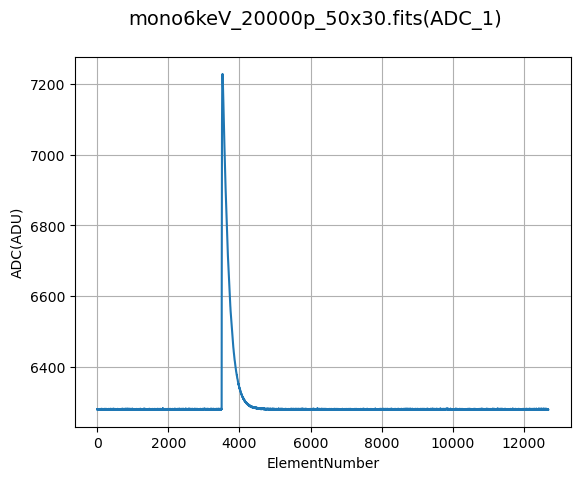

In [12]:
file = fits.open(templateRecordsFile, memmap=True)
fileTab = file['TESRECORDS'].data
fileADC = fileTab['ADC']
file.close()

fig = plt.figure()
fig.suptitle(templateRecordsFile+'(ADC_1)', fontsize=14)

elementNumber = np.arange(fileADC[0].size)
plt.plot(elementNumber,fileADC[0])
plt.ylabel('ADC(ADU)')
plt.xlabel('ElementNumber')
plt.grid(True)
plt.show()

meanLast1000 = np.mean(fileADC[0][fileADC[0].size-1000:fileADC[0].size])

#fig.savefig(noiseRecordsFile+'_ADC_1.png', dpi=fig.dpi)

## BUILD THE LIBRARY

In [13]:
libraryFile = "optimal_filters_6keV_50x30_Dec2025.fits"

#largeFilter = 8192 # largest filter to be created (samples); power of 2 smaller filters will also be created

In [14]:
#libraryFile = "of_library_8192_Beascode.fits"
#templateRecordsFile = "OF_50x30/generate_optimal_filter_pulse_template_tmp.fits"
if not os.path.isfile(libraryFile):
    comm = ("teslib Recordfile=" + templateRecordsFile +
            " TesEventFile=myLibEvents.fits" +
            " monoenergy=" + str(templateKeV*1e3) +
            " LibraryFile=" + libraryFile +
            " NoiseFile=" + noiseSpectrumFile +
            " XMLFile=" + XMLxifusim +
            " threshold=6")
            #" XMLFile=" + XMLxifusim +
            #" nSgms=6")
    args = shlex.split(comm)
    try:
        print("Running tool TESLIB (building the library):", comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool TESLIB (building the library):")
        print(comm)
        chdir(cwd)
        rmtree(tmpDir)
        raise